<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 1032, '日付': '2021-05-09T08:00:00.000Z'},
 {'小計': 573, '日付': '2021-05-10T08:00:00.000Z'},
 {'小計': 925, '日付': '2021-05-11T08:00:00.000Z'},
 {'小計': 969, '日付': '2021-05-12T08:00:00.000Z'},
 {'小計': 1010, '日付': '2021-05-13T08:00:00.000Z'},
 {'小計': 854, '日付': '2021-05-14T08:00:00.000Z'},
 {'小計': 772, '日付': '2021-05-15T08:00:00.000Z'},
 {'小計': 542, '日付': '2021-05-16T08:00:00.000Z'},
 {'小計': 419, '日付': '2021-05-17T08:00:00.000Z'},
 {'小計': 732, '日付': '2021-05-18T08:00:00.000Z'},
 {'小計': 766, '日付': '2021-05-19T08:00:00.000Z'},
 {'小計': 843, '日付': '2021-05-20T08:00:00.000Z'},
 {'小計': 649, '日付': '2021-05-21T08:00:00.000Z'},
 {'小計': 602, '日付': '2021-05-22T08:00:00.000Z'},
 {'小計': 535, '日付': '2021-05-23T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-05-19 17:00:00+09:00,559,0,766,2021-05-19 17:00:00+09:00
2021-05-20 17:00:00+09:00,489,0,843,2021-05-20 17:00:00+09:00
2021-05-21 17:00:00+09:00,0,0,649,2021-05-21 17:00:00+09:00
2021-05-22 17:00:00+09:00,0,0,602,2021-05-22 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-05-19 17:00:00+09:00,559,0,766,2021-05-19 17:00:00+09:00,603.000000,4221.0,0.0,0.0,727.857143,5095.0
2021-05-20 17:00:00+09:00,489,0,843,2021-05-20 17:00:00+09:00,581.857143,4073.0,0.0,0.0,704.000000,4928.0
2021-05-21 17:00:00+09:00,0,0,649,2021-05-21 17:00:00+09:00,496.571429,3476.0,0.0,0.0,674.714286,4723.0
2021-05-22 17:00:00+09:00,0,0,602,2021-05-22 17:00:00+09:00,404.428571,2831.0,0.0,0.0,650.428571,4553.0
2021-05-23 17:00:00+09:00,0,0,535,2021-05-23 17:00:00+09:00,331.428571,2320.0,0.0,0.0,649.428571,4546.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-05-09 17:00:00+09:00,644,0,1032,2021-05-09 17:00:00+09:00,760.000000,5320.0,0.0,0.0,798.428571,5589.0,'21w18,Sun
2021-05-10 17:00:00+09:00,688,0,573,2021-05-10 17:00:00+09:00,762.285714,5336.0,0.0,0.0,779.142857,5454.0,'21w19,Mon
2021-05-11 17:00:00+09:00,593,0,925,2021-05-11 17:00:00+09:00,749.571429,5247.0,0.0,0.0,824.285714,5770.0,'21w19,Tue
2021-05-12 17:00:00+09:00,622,0,969,2021-05-12 17:00:00+09:00,733.285714,5133.0,0.0,0.0,874.000000,6118.0,'21w19,Wed
2021-05-13 17:00:00+09:00,637,0,1010,2021-05-13 17:00:00+09:00,670.428571,4693.0,0.0,0.0,933.857143,6537.0,'21w19,Thu
2021-05-14 17:00:00+09:00,597,0,854,2021-05-14 17:00:00+09:00,644.428571,4511.0,0.0,0.0,926.285714,6484.0,'21w19,Fri
2021-05-15 17:00:00+09:00,645,0,772,2021-05-15 17:00:00+09:00,632.285714,4426.0,0.0,0.0,876.428571,6135.0,'21w19,Sat
2021-05-16 17:00:00+09:00,511,0,542,2021-05-16 17:00:00+09:00,613.285714,4293.0,0.0,0.0,806.428571,5645.0,'21w19,Sun
2021-05-17 17:00:00+09:00,703,0,419,2021-05-17 17:00:00+09:00,615.428571,4308.0,0.0,0.0,784.428571,5491.0,'21w20,Mon
2021-05-18 17:00:00+09:00,569,0,732,2021-05-18 17:00:00+09:00,612.000000,4284.0,0.0,0.0,756.857143,5298.0,'21w20,Tue


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-05-02 17:00:00+09:00,833.142857,5832
2021-05-09 17:00:00+09:00,798.428571,5589
2021-05-16 17:00:00+09:00,806.428571,5645
2021-05-23 17:00:00+09:00,649.428571,4546
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-05-09 17:00:00+09:00,644,0,1032,2021-05-09 17:00:00+09:00,760.000000,5320.0,0.0,0.0,798.428571,5589.0,'21w18,Sun,798.428571,5589.0
2021-05-10 17:00:00+09:00,688,0,573,2021-05-10 17:00:00+09:00,762.285714,5336.0,0.0,0.0,779.142857,5454.0,'21w19,Mon,NaN,NaN
2021-05-11 17:00:00+09:00,593,0,925,2021-05-11 17:00:00+09:00,749.571429,5247.0,0.0,0.0,824.285714,5770.0,'21w19,Tue,NaN,NaN
2021-05-12 17:00:00+09:00,622,0,969,2021-05-12 17:00:00+09:00,733.285714,5133.0,0.0,0.0,874.000000,6118.0,'21w19,Wed,NaN,NaN
2021-05-13 17:00:00+09:00,637,0,1010,2021-05-13 17:00:00+09:00,670.428571,4693.0,0.0,0.0,933.857143,6537.0,'21w19,Thu,NaN,NaN
2021-05-14 17:00:00+09:00,597,0,854,2021-05-14 17:00:00+09:00,644.428571,4511.0,0.0,0.0,926.285714,6484.0,'21w19,Fri,NaN,NaN
2021-05-15 17:00:00+09:00,645,0,772,2021-05-15 17:00:00+09:00,632.285714,4426.0,0.0,0.0,876.428571,6135.0,'21w19,Sat,NaN,NaN
2021-05-16 17:00:00+09:00,511,0,542,2021-05-16 17:00:00+09:00,613.285714,4293.0,0.0,0.0,806.428571,5645.0,'21w19,Sun,806.428571,5645.0
2021-05-17 17:00:00+09:00,703,0,419,2021-05-17 17:00:00+09:00,615.428571,4308.0,0.0,0.0,784.428571,5491.0,'21w20,Mon,NaN,NaN
2021-05-18 17:00:00+09:00,569,0,732,2021-05-18 17:00:00+09:00,612.000000,4284.0,0.0,0.0,756.857143,5298.0,'21w20,Tue,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

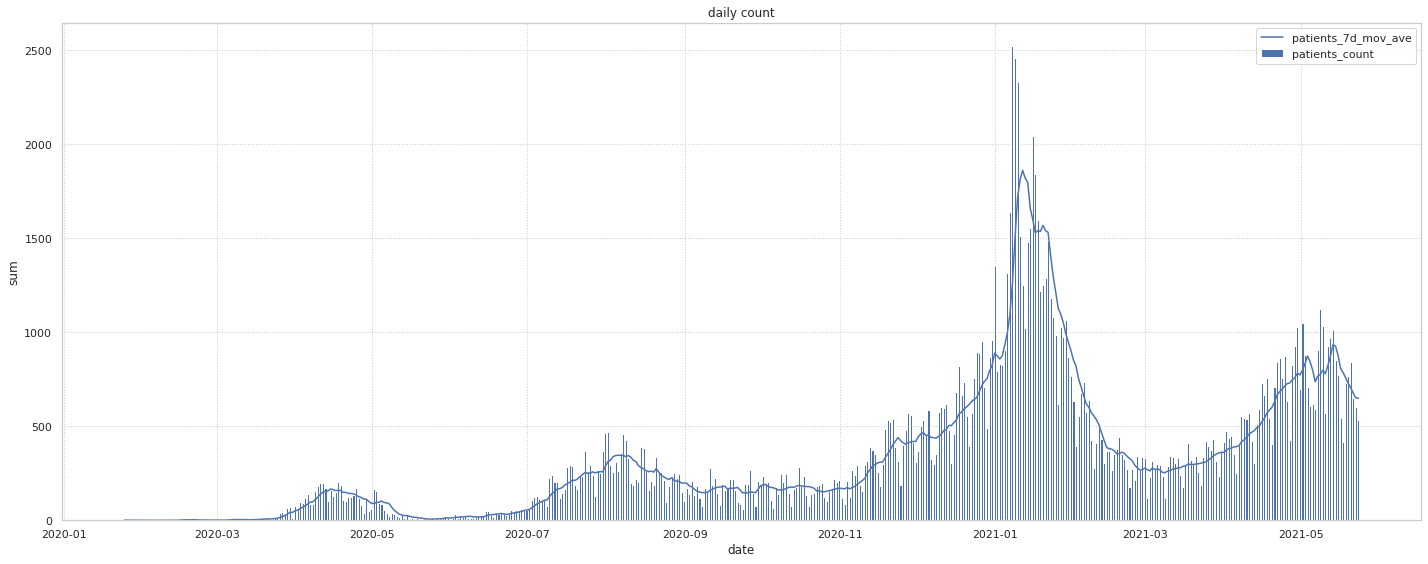

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
471,1.620547e+09,2021,5,9,0,0,0,1,0,0,0,471,0,397,644,760.000000,5320.0,0,0.0,0.0,1032,798.428571,5589.0
472,1.620634e+09,2021,5,10,0,1,0,0,0,0,0,472,0,398,688,762.285714,5336.0,0,0.0,0.0,573,779.142857,5454.0
473,1.620720e+09,2021,5,11,0,0,0,0,0,1,0,473,0,399,593,749.571429,5247.0,0,0.0,0.0,925,824.285714,5770.0
474,1.620806e+09,2021,5,12,0,0,0,0,0,0,1,474,0,400,622,733.285714,5133.0,0,0.0,0.0,969,874.000000,6118.0
475,1.620893e+09,2021,5,13,0,0,0,0,1,0,0,475,0,401,637,670.428571,4693.0,0,0.0,0.0,1010,933.857143,6537.0
476,1.620979e+09,2021,5,14,1,0,0,0,0,0,0,476,0,402,597,644.428571,4511.0,0,0.0,0.0,854,926.285714,6484.0
477,1.621066e+09,2021,5,15,0,0,1,0,0,0,0,477,0,403,645,632.285714,4426.0,0,0.0,0.0,772,876.428571,6135.0
478,1.621152e+09,2021,5,16,0,0,0,1,0,0,0,478,0,404,511,613.285714,4293.0,0,0.0,0.0,542,806.428571,5645.0
479,1.621238e+09,2021,5,17,0,1,0,0,0,0,0,479,0,405,703,615.428571,4308.0,0,0.0,0.0,419,784.428571,5491.0
480,1.621325e+09,2021,5,18,0,0,0,0,0,1,0,480,0,406,569,612.000000,4284.0,0,0.0,0.0,732,756.857143,5298.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            486 non-null    float64
 1   year                 486 non-null    int64  
 2   month                486 non-null    int64  
 3   day                  486 non-null    int64  
 4   Fri                  486 non-null    uint8  
 5   Mon                  486 non-null    uint8  
 6   Sat                  486 non-null    uint8  
 7   Sun                  486 non-null    uint8  
 8   Thu                  486 non-null    uint8  
 9   Tue                  486 non-null    uint8  
 10  Wed                  486 non-null    uint8  
 11  passed               486 non-null    int64  
 12  emergency            486 non-null    int64  
 13  em_passed            486 non-null    int64  
 14  contacts_count       486 non-null    int64  
 15  contacts_7d_mov_ave  486 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,4.860000e+02,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000,486.000000
mean,1.600805e+09,2020.294239,5.711934,15.699588,0.144033,0.141975,0.144033,0.144033,0.141975,0.141975,0.141975,242.500000,0.100823,174.209877,674.022634,673.096659,4711.668724,758.269547,758.269547,5307.886831,322.602881,318.607378,2230.218107
std,1.213405e+07,0.456169,3.363133,8.793172,0.351485,0.349384,0.351485,0.351485,0.349384,0.349384,0.349384,140.440379,0.301405,132.206123,442.441019,428.287086,2998.021960,873.607815,781.349686,5469.447799,375.343434,354.521886,2481.683356
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.590329e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,121.250000,0.000000,47.250000,387.750000,388.321429,2718.250000,0.000000,0.000000,0.000000,57.250000,55.571429,389.000000
50%,1.600805e+09,2020.000000,5.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,242.500000,0.000000,168.500000,551.000000,569.642857,3987.500000,351.000000,854.285714,5980.000000,206.500000,197.214286,1380.500000
75%,1.611281e+09,2021.000000,8.750000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,363.750000,0.000000,289.750000,784.750000,775.250000,5426.750000,1362.750000,1362.607143,9538.250000,428.000000,423.535714,2964.750000
max,1.621757e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,485.000000,1.000000,411.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,2520.000000,1861.142857,13028.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.789297,0.087858,-0.011500,-0.002924,-0.004349,2.701452e-18,0.002924,0.004349,-0.001450,0.001450,1.000000e+00,-0.344890,0.995053,-0.277707,-0.256973,-0.256967,-0.515917,-0.556061,-0.556061,0.638215,0.675424,0.675439
year,7.892968e-01,1.000000,-0.540014,-0.054508,0.005186,-0.003913,5.186153e-03,0.005186,-0.003913,-0.003913,-0.003913,7.892968e-01,-0.216211,0.810542,-0.264084,-0.237966,-0.237964,-0.561016,-0.627258,-0.627258,0.606210,0.661179,0.661180
month,8.785768e-02,-0.540014,1.000000,-0.012972,-0.013667,0.001538,-8.434108e-03,-0.004946,0.012066,0.005048,0.008557,8.785768e-02,-0.119775,0.046305,0.051735,0.037243,0.037247,0.205423,0.259486,0.259486,-0.111333,-0.150747,-0.150727
day,-1.150042e-02,-0.054508,-0.012972,1.000000,0.014029,-0.012934,-6.479056e-04,0.006023,0.003173,-0.007565,-0.002196,-1.150042e-02,-0.000218,-0.010479,-0.020014,-0.015175,-0.015179,0.013207,-0.001465,-0.001465,-0.013545,-0.004538,-0.004553
Fri,-2.923867e-03,0.005186,-0.013667,0.014029,1.000000,-0.166863,-1.682692e-01,-0.168269,-0.166863,-0.166863,-0.166863,-2.923867e-03,-0.001121,-0.001806,-0.022401,-0.004388,-0.004386,0.033729,-0.003253,-0.003253,0.045570,-0.001096,-0.001105
Mon,-4.349137e-03,-0.003913,0.001538,-0.012934,-0.166863,1.000000,-1.668625e-01,-0.166863,-0.165468,-0.165468,-0.165468,-4.349137e-03,0.000846,-0.004530,0.042635,0.001678,0.001679,0.147935,0.002454,0.002454,-0.126860,-0.002920,-0.002918
Sat,2.701452e-18,0.005186,-0.008434,-0.000648,-0.168269,-0.166863,1.000000e+00,-0.168269,-0.166863,-0.166863,-0.166863,-5.935807e-19,-0.001121,0.000812,0.041253,-0.004388,-0.004386,-0.170133,-0.003253,-0.003253,0.061965,0.000325,0.000318
Sun,2.923867e-03,0.005186,-0.004946,0.006023,-0.168269,-0.166863,-1.682692e-01,1.000000,-0.166863,-0.166863,-0.166863,2.923867e-03,-0.001121,0.003430,-0.025888,-0.004388,-0.004386,-0.156978,-0.003253,-0.003253,-0.035199,0.001584,0.001583
Thu,4.349137e-03,-0.003913,0.012066,0.003173,-0.166863,-0.165468,-1.668625e-01,-0.166863,1.000000,-0.165468,-0.165468,4.349137e-03,0.000846,0.003326,-0.003089,0.004861,0.004862,0.044715,0.002454,0.002454,0.079248,0.002643,0.002649
Tue,-1.449712e-03,-0.003913,0.005048,-0.007565,-0.166863,-0.165468,-1.668625e-01,-0.166863,-0.165468,1.000000,-0.165468,-1.449712e-03,0.000846,-0.001941,-0.021629,0.002798,0.002799,0.060340,0.002454,0.002454,-0.035244,-0.001181,-0.001177


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,1.621411e+09,0,0,0,0,0,0,1,481,0,407,559,0,766,727.857143,5095.0
482,1.621498e+09,0,0,0,0,1,0,0,482,0,408,489,0,843,704.000000,4928.0
483,1.621584e+09,1,0,0,0,0,0,0,483,0,409,0,0,649,674.714286,4723.0
484,1.621670e+09,0,0,1,0,0,0,0,484,0,410,0,0,602,650.428571,4553.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
481,1.621411e+09,481,0,766,727.857143,5095.0
482,1.621498e+09,482,0,843,704.000000,4928.0
483,1.621584e+09,483,0,649,674.714286,4723.0
484,1.621670e+09,484,0,602,650.428571,4553.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

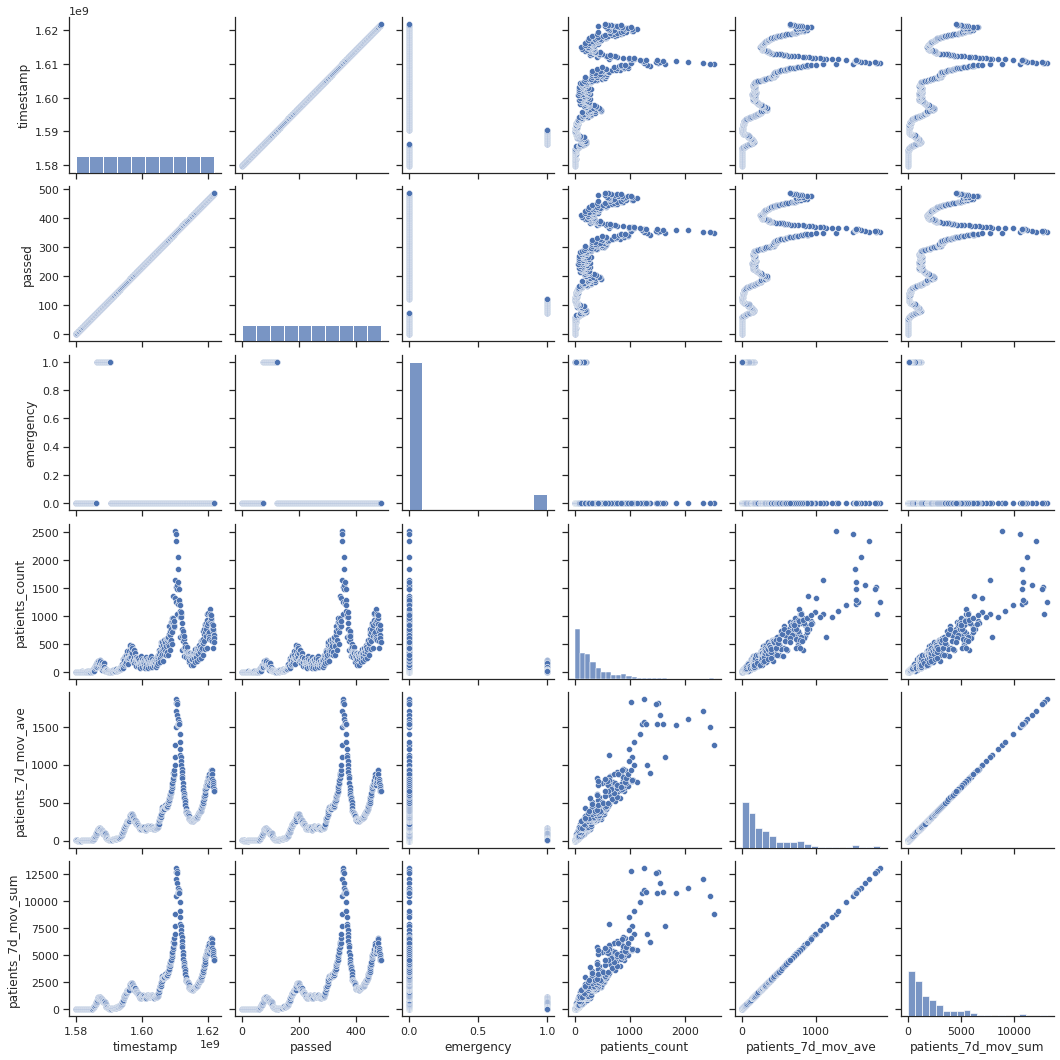

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.10
